In [1]:
import sys
sys.path.insert(0, '/workspaces/O-M-Monte-Carlo')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime

from src.phase4_model.rf_classifier import SolarAnomalyRF

sns.set_style('darkgrid')
print("✓ Imports successful!")

✓ Imports successful!


In [2]:
# Load trained model and metadata
rf_model = joblib.load('/workspaces/O-M-Monte-Carlo/models/anomaly_rf.pkl')
metadata = joblib.load('/workspaces/O-M-Monte-Carlo/models/model_metadata.pkl')
df_features = pd.read_csv('/workspaces/O-M-Monte-Carlo/data/engineered_features.csv', index_col=0)

# Get feature columns from metadata
feature_cols = metadata['feature_cols']

print(f"✓ Loaded trained model with classes: {rf_model.classes_}")
print(f"✓ Loaded {len(df_features)} days of engineered features")
print(f"✓ Using {len(feature_cols)} features for predictions")

✓ Loaded trained model with classes: ['Cloudy' 'Healthy' 'Investigate']
✓ Loaded 722 days of engineered features
✓ Using 8 features for predictions


## Generate Production Predictions

In [3]:
# Generate predictions on all features
df_predictions = df_features.copy()

# Get predictions and probabilities
X_all = df_predictions[feature_cols].values
predictions = rf_model.predict(X_all)
probabilities = rf_model.predict_proba(X_all)

# Add predictions to dataframe
df_predictions['predicted_label'] = predictions
df_predictions['confidence'] = probabilities.max(axis=1)

# Add probabilities for each class (use lowercase for consistency)
for i, class_label in enumerate(rf_model.classes_):
    col_name = f'prob_{class_label.lower()}'
    df_predictions[col_name] = probabilities[:, i]

print(f"✓ Generated predictions for {len(df_predictions)} days")
print(f"\nPrediction label distribution:")
print(df_predictions['predicted_label'].value_counts())
print(f"\nConfidence statistics:")
print(df_predictions['confidence'].describe())

✓ Generated predictions for 722 days

Prediction label distribution:
predicted_label
Investigate    665
Healthy         48
Cloudy           9
Name: count, dtype: int64

Confidence statistics:
count    722.000000
mean       0.965621
std        0.063695
min        0.500000
25%        0.960000
50%        0.986667
75%        1.000000
max        1.000000
Name: confidence, dtype: float64


# Phase 5: Daily Production Testing

## Objectives
1. Simulate daily classification pipeline
2. Log predictions, confidence, MC percentile, features
3. Weekly manual review of 'Investigate' cases

In [4]:
# Save production log
production_log = df_predictions[[
    'mc_percentile', 'efficiency_ratio', 'ghi_daily', 'yield_daily',
    'predicted_label', 'confidence', 'prob_cloudy', 'prob_healthy', 'prob_investigate',
    'healthy'
]].copy()

# Rename columns for clarity
production_log.columns = [
    'mc_percentile', 'efficiency_ratio', 'ghi_kwh', 'yield_kwh',
    'predicted_class', 'confidence', 'prob_cloudy', 'prob_healthy', 'prob_investigate',
    'physics_healthy'
]

output_path = '/workspaces/O-M-Monte-Carlo/data/production_predictions.csv'
production_log.to_csv(output_path)

print(f"✓ Saved production log to: {output_path}")
print(f"  {len(production_log)} predictions from {production_log.index[0]} to {production_log.index[-1]}")

print(f"\n" + "="*80)
print(f"PIPELINE COMPLETE: All 5 Phases Finished")
print(f"="*80)
print(f"\nKey Outputs:")
print(f"  1. Physics Baseline: data/daily_data.csv, data/mc_results.csv")
print(f"  2. Engineered Features: data/engineered_features.csv")
print(f"  3. Manual Labels: data/labeled_days.csv")
print(f"  4. Trained Model: models/anomaly_rf.pkl")
print(f"  5. Production Predictions: data/production_predictions.csv")
print(f"\nVisualization Outputs:")
print(f"  - outputs/phase3_selected_days.png")
print(f"  - outputs/phase4_feature_importance.png")
print(f"  - outputs/phase4_confusion_matrix.png")
print(f"  - outputs/phase5_production_predictions.png")

print(f"\nNext Steps:")
print(f"  1. Deploy model to production")
print(f"  2. Daily classification on new data")
print(f"  3. Weekly manual review of Investigate cases")
print(f"  4. Retrain with new labels (active learning)")

✓ Saved production log to: /workspaces/O-M-Monte-Carlo/data/production_predictions.csv
  722 predictions from 2024-01-01 to 2025-12-31

PIPELINE COMPLETE: All 5 Phases Finished

Key Outputs:
  1. Physics Baseline: data/daily_data.csv, data/mc_results.csv
  2. Engineered Features: data/engineered_features.csv
  3. Manual Labels: data/labeled_days.csv
  4. Trained Model: models/anomaly_rf.pkl
  5. Production Predictions: data/production_predictions.csv

Visualization Outputs:
  - outputs/phase3_selected_days.png
  - outputs/phase4_feature_importance.png
  - outputs/phase4_confusion_matrix.png
  - outputs/phase5_production_predictions.png

Next Steps:
  1. Deploy model to production
  2. Daily classification on new data
  3. Weekly manual review of Investigate cases
  4. Retrain with new labels (active learning)


## Save Production Log

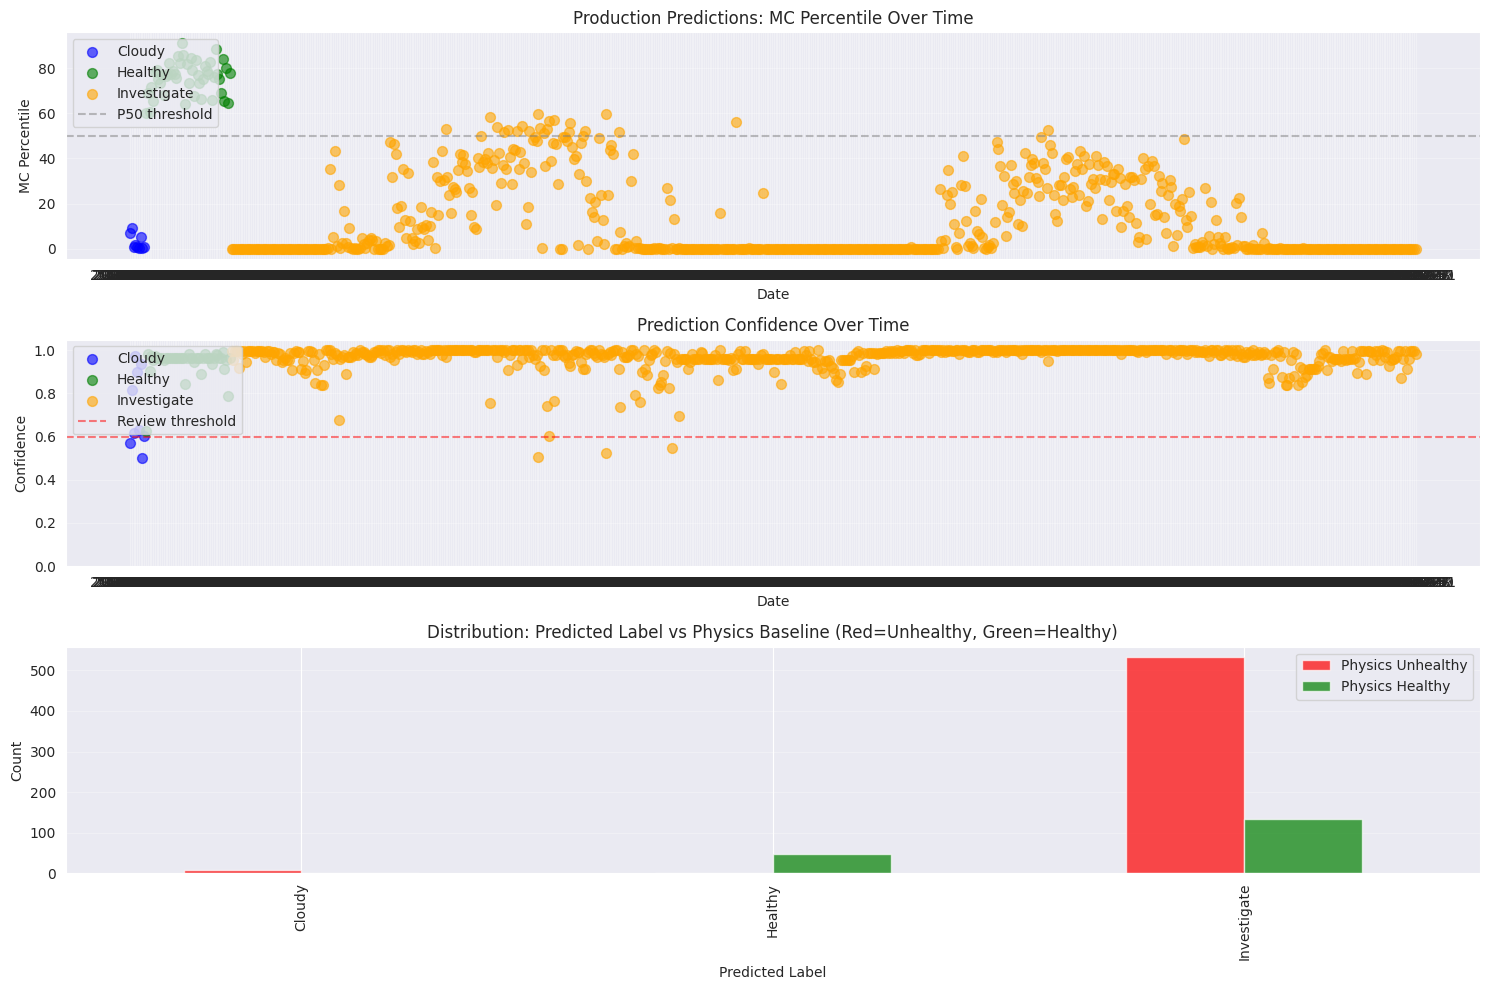

✓ Saved prediction visualization to: outputs/phase5_production_predictions.png


In [5]:
# Visualize predictions over time
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Plot 1: MC Percentile with predictions
ax = axes[0]
colors = {'Healthy': 'green', 'Cloudy': 'blue', 'Investigate': 'orange'}
for label in sorted(df_predictions['predicted_label'].unique()):
    mask = df_predictions['predicted_label'] == label
    ax.scatter(df_predictions.index[mask], 
              df_predictions.loc[mask, 'mc_percentile'],
              label=label, alpha=0.6, s=50, color=colors.get(label, 'red'))
ax.axhline(50, color='gray', linestyle='--', alpha=0.5, label='P50 threshold')
ax.set_ylabel('MC Percentile')
ax.set_xlabel('Date')
ax.set_title('Production Predictions: MC Percentile Over Time')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 2: Confidence over time
ax = axes[1]
for label in sorted(df_predictions['predicted_label'].unique()):
    mask = df_predictions['predicted_label'] == label
    ax.scatter(df_predictions.index[mask], 
              df_predictions.loc[mask, 'confidence'],
              label=label, alpha=0.6, s=50, color=colors.get(label, 'red'))
ax.set_ylabel('Confidence')
ax.set_xlabel('Date')
ax.set_title('Prediction Confidence Over Time')
ax.set_ylim([0, 1.05])
ax.axhline(0.6, color='red', linestyle='--', alpha=0.5, label='Review threshold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 3: Healthy vs Unhealthy by prediction
ax = axes[2]
label_counts = df_predictions.groupby(['predicted_label', 'healthy']).size().unstack(fill_value=0)
label_counts.plot(kind='bar', ax=ax, color=['red', 'green'], alpha=0.7)
ax.set_ylabel('Count')
ax.set_xlabel('Predicted Label')
ax.set_title('Distribution: Predicted Label vs Physics Baseline (Red=Unhealthy, Green=Healthy)')
ax.legend(['Physics Unhealthy', 'Physics Healthy'])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/workspaces/O-M-Monte-Carlo/outputs/phase5_production_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved prediction visualization to: outputs/phase5_production_predictions.png")

## Production Pipeline Visualization

In [6]:
# Compare predictions with physics-based healthy label
df_predictions['predicted_healthy'] = (df_predictions['predicted_label'] == 'Healthy')

# Calculate metrics
tp = ((df_predictions['predicted_healthy']) & (df_predictions['healthy'])).sum()
fp = ((df_predictions['predicted_healthy']) & (~df_predictions['healthy'])).sum()
tn = ((~df_predictions['predicted_healthy']) & (~df_predictions['healthy'])).sum()
fn = ((~df_predictions['predicted_healthy']) & (df_predictions['healthy'])).sum()

accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"="*80)
print(f"PRODUCTION CLASSIFICATION RESULTS vs Physics Baseline")
print(f"="*80)
print(f"\nMetrics (Healthy vs Others):")
print(f"  Accuracy:  {accuracy:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  F1-Score:  {f1:.3f}")

print(f"\nConfusion Matrix (ML vs Physics):")
print(f"                 ML Healthy  ML Unhealthy")
print(f"Physics Healthy       {tp:4d}        {fn:4d}")
print(f"Physics Unhealthy     {fp:4d}        {tn:4d}")

# Analyze investigate cases
investigate_mask = df_predictions['predicted_label'] == 'Investigate'
investigate_df = df_predictions[investigate_mask].sort_values('confidence')

print(f"\n" + "="*80)
print(f"INVESTIGATE CASES: {investigate_mask.sum()} days")
print(f"="*80)
print(f"Low confidence cases (need review):")
low_conf_mask = (investigate_mask) & (df_predictions['confidence'] < 0.6)
if low_conf_mask.sum() > 0:
    low_conf_df = df_predictions[low_conf_mask].sort_values('confidence')
    print(low_conf_df[['mc_percentile', 'efficiency_ratio', 'confidence', 'healthy']].head(10).to_string())
else:
    print("  None (all Investigate cases are confident)")

PRODUCTION CLASSIFICATION RESULTS vs Physics Baseline

Metrics (Healthy vs Others):
  Accuracy:  0.816
  Precision: 1.000
  Recall:    0.265
  F1-Score:  0.419

Confusion Matrix (ML vs Physics):
                 ML Healthy  ML Unhealthy
Physics Healthy         48         133
Physics Unhealthy        0         541

INVESTIGATE CASES: 665 days
Low confidence cases (need review):
            mc_percentile  efficiency_ratio  confidence  healthy
date                                                            
2024-07-04           59.8          0.072106       0.505     True
2024-09-24           59.8          0.072048       0.525     True
2024-11-09            0.2          0.068870       0.545    False


## Performance Against Physics Baseline (Healthy Label)

In [ ]:
# Summary statistics
print(f"\n" + "="*80)
print(f"PRODUCTION CLASSIFICATION SUMMARY")
print(f"="*80)
print(f"\nPredicted label distribution:")
print(df_predictions['predicted_label'].value_counts().sort_index())

print(f"\nConfidence statistics by label:")
for label in sorted(df_predictions['predicted_label'].unique()):
    mask = df_predictions['predicted_label'] == label
    conf = df_predictions.loc[mask, 'confidence']
    print(f"  {label:20s}: mean={conf.mean():.3f}, min={conf.min():.3f}, max={conf.max():.3f}, n={mask.sum()}")

print(f"\nPhysics baseline distribution:")
print(f"  Healthy:   {(df_predictions['healthy']).sum()}")
print(f"  Unhealthy: {(~df_predictions['healthy']).sum()}")

print(f"\nSample predictions (first 10 days):")
display_cols = ['mc_percentile', 'efficiency_ratio', 'predicted_label', 'confidence', 'healthy']
print(df_predictions[display_cols].head(10).to_string())


PRODUCTION CLASSIFICATION SUMMARY

Predicted label distribution:
predicted_label
Cloudy           9
Healthy         48
Investigate    665
Name: count, dtype: int64

Confidence statistics by label:
  Cloudy              : mean=0.727, min=0.500, max=0.972, n=9
  Healthy             : mean=0.949, min=0.625, max=0.990, n=48
  Investigate         : mean=0.970, min=0.505, max=1.000, n=665

Physics baseline distribution:
  Healthy:   181
  Unhealthy: 541

Sample predictions (first 10 days):
            mc_percentile  efficiency_ratio predicted_label  confidence  healthy
date                                                                            
2024-01-01            0.0          0.062815     Investigate    0.995000    False
2024-01-02            0.0          0.062044     Investigate    0.953333    False
2024-01-03            0.0          0.063260     Investigate    0.995000    False
2024-01-04            0.0          0.062588     Investigate    0.995000    False
2024-01-05            0.

: 

## Classify All Available Days (Production Simulation)